## Import Libraries & Scripts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid
sns.set_style("darkgrid")
sns.set_palette("rainbow")
sns.set_context("talk")
from datetime import datetime

In [2]:
import sys  
sys.path.insert(0, r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SupplyChain_RL\scripts')

In [3]:
from sac2019 import SACAgent
from supply_chain_env import SupplyChainEnv
import math
import random
import torch

In [4]:
import os

## Utilities & Functions

In [5]:
def run_model(con_mat,max_episodes,max_steps,initial_factory_stock,initial_warehouse_stock,initial_complete_state,path,base_filename): 
    '''
    If passing initial actiom no need to pass initial state
    If passing initial state initial action is not needed
    '''
    episode_rewards = []
    
    for j in range(max_episodes):
        # Reset
        if initial_complete_state is None:
            #state = env.reset([0], [300, 300])
            state = env.reset(initial_factory_stock,initial_warehouse_stock)
            print('Initial STATE not passed as argument')
            print('Initial State',state)
        else:
            print('Initial STATE passed as argument')
            print('Initial State',initial_complete_state)
            ##[  0 300 300   0   0   0   0   0   0   0   0]
        episode_reward = 0
        print('-------------Episode------------',j)
        # Demand profile
        
        print('------------------------------------Demand of N Warehouses-------------------------------------')
        
        for i in range(0,len(initial_warehouse_stock)):
            globals()[f"d{i+1}"]=[]
            globals()[f"d{i+1}_max"]=random.uniform(150, 180)
            #d1 = []
            #d2 = []
            #d1_max = random.uniform(150, 180)
            #d2_max = random.uniform(150, 180)
            
        for k in range(max_steps):
            for i in range(0,len(initial_warehouse_stock)):
                if i%2==0:
                    globals()[f"d{i+1}_temp"]=globals()[f"d{i+1}_max"] / 2 * math.sin(2 * pi * k / 12) + globals()[f"d{i+1}_max"] / 2 + random.uniform(0, 2)
                else:
                    globals()[f"d{i+1}_temp"]=-globals()[f"d{i+1}_max"] / 2 * math.sin(2 * pi * k / 8) + globals()[f"d{i+1}_max"] / 2 + random.uniform(0, 2)
                    #d1_temp = d1_max / 2 * math.sin(2 * pi * k / 12) + d1_max / 2 + random.uniform(0, 2)
                    #d2_temp = - d2_max / 2 * math.sin(2 * pi * k / 8) + d2_max / 2 + random.uniform(0, 2)
                    #d1_temp = d1_max/2 * math.exp(-k/10) + d1_max/2 + random.uniform(0, 10)
                    #d2_temp = d2_max/2 * math.exp(-k/10) + d2_max/2 + random.uniform(0, 10)
                globals()[f"d{i+1}"].append(globals()[f"d{i+1}_temp"])
                #d1.append(round(d1_temp))
                #d2.append(round(d2_temp))
        
        for i in range(0,len(initial_warehouse_stock)):
            print('Demand-',i+1)
            print(globals()[f"d{i+1}"])
        demand=[]
        for i in range(0,len(initial_warehouse_stock)):
            demand.append(globals()[f"d{i+1}"])
        print('Full Demand',demand)
        #demand=[d1,d2]
        print('------------------------------------Action Modifying and Editing--------------------------------')
        for i in range(max_steps):
            action = agent.get_action(state)
            print('Initial Action')
            print(action)
            
            dd=[]
            for j in range(0,len(initial_warehouse_stock)):
                dd.append(globals()[f"d{j+1}"][i])
            print(dd)
            
            ff=[]
            ww=[]
            for f in range(len(initial_factory_stock)): #0,1
                #globals()[f"a{f}_temp"]=0
                globals()[f"a{f}_list"]=[]
                for w in range(len(initial_warehouse_stock)): #0,1,2
                    if con_mat[f][w]==1:
                        temp=len(initial_factory_stock)+len(initial_warehouse_stock)*f+w
                        globals()[f"a{len(initial_factory_stock)+len(initial_warehouse_stock)*f+w}_temp"]=round(action[temp])
                        globals()[f"a{f}_list"].append(round(action[temp]))
                    elif con_mat[f][w]==0:
                        temp=len(initial_factory_stock)+len(initial_warehouse_stock)*f+w
                        globals()[f"a{len(initial_factory_stock)+len(initial_warehouse_stock)*f+w}_temp"]=0
                        globals()[f"a{f}_list"].append(0)
                ww.append(globals()[f"a{f}_list"])    
                globals()[f"a{f}_temp"]=np.sum(globals()[f"a{f}_list"])
                ff.append(np.sum(globals()[f"a{f}_list"]))
                print(globals()[f"a{f}_temp"])
            print('Factory Actions:-',ff)
            print('Warehouse Actions:-',ww)
            
            #for i in range(0,len(initial_factory_stock)):
            #    globals()[f"a{i+1}_temp"]=round(globals()[f"action[i+1]"])
            #
            #    a1_temp = round(action[1])
            #    a2_temp = round(action[2])
            #    a0_temp = round(action[0]) + a1_temp + a2_temp
            #    print('a1_temp:',a1_temp)
            #    print('a2_temp:',a2_temp)
            #    print('a0_temp:',a0_temp)
            print(ff, ww, dd)
            next_state, reward, done = env.step(ff, ww, dd)
            print('Next State:',next_state)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            episode_reward += reward

            if len(agent.replay_buffer) > batch_size:
                agent.update(batch_size)

            if done or i == max_steps - 1:
                episode_rewards.append(episode_reward)
                print("Episode ", j, "Reward: %.4f" % episode_reward, 'a1_final: %.2f' % env.a_w[0][0][-1], 'a2_final: %.2f' % env.a_w[0][1][-1], 'a0_final: %.2f' % env.a_f[0][-1])
                print("Episode ", j, "Reward: %.4f" % episode_reward, 's0_final: %.2f' % env.s_f[0][-1], 's1_final: %.2f' % env.s_w[0][-1], 's2_final: %.2f' % env.s_w[1][-1])
                print((env.a_w))
                print((env.a_f))
                print(env.s_f)
                print(env.s_w)
                if j == max_episodes - 1:
                    a1f = env.a_w[0][0]
                    a2f = env.a_w[0][1]
                    a0f = env.a_f[0]
                    s1f = env.s_w[0]
                    s2f = env.s_w[1]
                    s0f = env.s_f[0]
                break

            state = next_state
    #Save RL Model
    
    isFile = os.path.isfile(path)
    if isFile:
        final_filename=path
        print('Enter right path')
    else:
        final_filename=os.path.join(path, base_filename)
        torch.save(agent, final_filename)
        print('Model Saved')
    #torch.save(agent.state_dict(), path)
    #file_name=os.path.join(path,'rewards')
    #file_name +='epi_rewards_new.dat'
    #np.savetxt(file_name, episode_rewards)
    return episode_rewards,env.a_f,env.a_w,env.s_w,env.s_f,demand

In [6]:
def predict(max_steps,initial_factory_stock,initial_warehouse_stock,initial_complete_state,path,base_filename,demand):
    '''
    If passing initial actiom no need to pass initial state
    If passing initial state initial action is not needed
    '''
    step_rewards=[]
    
    isFile = os.path.isfile(path)
    if isFile:
        final_filename=path
        agent=torch.load(final_filename)
        print('Model loaded')
    else:
        final_filename=os.path.join(path, base_filename)
        agent=torch.load(final_filename)
        print('Model loaded')
        
    if initial_complete_state is None:
        #state = env.reset([0], [300, 300])
        state = env.reset(initial_factory_stock,initial_warehouse_stock)
        print('Initial STATE not passed as argument')
        print('Initial State',state)
    else:
        print('Initial STATE passed as argument')
        print('Initial State',initial_complete_state)
            ##[  0 300 300   0   0   0   0   0   0   0   0]
            
    for i in range(0,len(initial_warehouse_stock)):
        globals()[f"d{i+1}"]=demand[i]
        
        
    
    ##length of demand should equal time steps
    
    for i in range(max_steps):
        action = agent.get_action(state)
        
        print('Initial Action')
        print(action)
        
        
        print('-------------------------Demand-------------------------------------')
        dd=[]
        for j in range(0,len(initial_warehouse_stock)):
            dd.append(globals()[f"d{j+1}"][i])
        print('Demand:-',dd)
        
        print('-------------------------Action-------------------------------------')
        ff=[]
        ww=[]
        for f in range(len(initial_factory_stock)): #0,1
            #globals()[f"a{f}_temp"]=0
            globals()[f"a{f}_list"]=[]
            for w in range(len(initial_warehouse_stock)): #0,1,2
                if con_mat[f][w]==1:
                    temp=len(initial_factory_stock)+len(initial_warehouse_stock)*f+w
                    globals()[f"a{len(initial_factory_stock)+len(initial_warehouse_stock)*f+w}_temp"]=round(action[temp])
                    globals()[f"a{f}_list"].append(round(action[temp]))
                elif con_mat[f][w]==0:
                    temp=len(initial_factory_stock)+len(initial_warehouse_stock)*f+w
                    globals()[f"a{len(initial_factory_stock)+len(initial_warehouse_stock)*f+w}_temp"]=0
                    globals()[f"a{f}_list"].append(0)
            ww.append(globals()[f"a{f}_list"])    
            globals()[f"a{f}_temp"]=np.sum(globals()[f"a{f}_list"])
            ff.append(np.sum(globals()[f"a{f}_list"]))
            print(globals()[f"a{f}_temp"])
        print('Factory Actions:-',ff)
        print('Warehouse Actions:-',ww)
        
        print(ff, ww, dd)
        next_state, reward, done = env.step(ff, ww, dd)
#         a1_temp = round(action[1])
#         a2_temp = round(action[2])
#         a0_temp = round(action[0]) + a1_temp + a2_temp
#         print('a1_temp:',a1_temp)
#         print('a2_temp:',a2_temp)
#         print('a0_temp:',a0_temp)
#         print([a0_temp], [[a1_temp, a2_temp]], [d1[i], d2[i]])
#         next_state, reward, done = env.step([a0_temp], [[a1_temp, a2_temp]], [d1[i], d2[i]])
        print('Next State:',next_state)
        step_rewards.append(reward)
#        if done or i == max_steps - 1:
#            step_rewards.append(reward)
#             print("Episode ", j, "Reward: %.4f" % episode_reward, 'a1_final: %.2f' % env.a_w[0][0][-1], 'a2_final: %.2f' % env.a_w[0][1][-1], 'a0_final: %.2f' % env.a_f[0][-1])
#             print("Episode ", j, "Reward: %.4f" % episode_reward, 's0_final: %.2f' % env.s_f[0][-1], 's1_final: %.2f' % env.s_w[0][-1], 's2_final: %.2f' % env.s_w[1][-1])
#             print((env.a_w))
#             print((env.a_f))
#             print(env.s_f)
#             print(env.s_w)
    return step_rewards,env.a_f,env.a_w,env.s_w,env.s_f,demand

In [7]:
def visualize(train_predict,episode_rewards,action_factory,action_warehouse,stock_warehouse,stock_factory,demand):
    
    factory_num==len(stock_factory)
    warehouse_num=len(stock_warehouse)
    
    col_factory=['Stock at Factory_'+str(i) for i in range(0,factory_num)]
    col_stock=['Stock at WH_'+str(i) for i in range(0,warehouse_num)]
    col_shipment=['Shipping to WH_'+str(i) for i in range(0,warehouse_num)]
    col_production=['Production at Factory_'+str(i) for i in range(0,factory_num)]
    col_demand=['Demand at WH_'+str(i) for i in range(0,warehouse_num)]
    col_merged=[]
    for i in range(0,factory_num):
        col_merged.append('Production at Factory_'+str(i))
        for j in range(0,warehouse_num):
            col_merged.append('Shipping to WH_'+str(j)+' from Factory_'+str(i))
    
    if train_predict=='train':
        col_rewards=["Per Episode Reward","Cumulative Reward"]
        title_rewards='Rewards Per Episode'
        demand_rewards='Training Demands @Warehouse'
        shipment_rewards='TrainingShipments to WH'
        stocks_rewards='Training Stock levels'
    else:
        col_rewards=["Per Step Reward","Cumulative Reward"]
        title_rewards='Rewards Per Step'
        demand_rewards='Predicting Demands @Warehouse'
        shipment_rewards='Predicting Shipments to WH'
        stocks_rewards='Predicting Stock levels'
    
    plt.figure(1)
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(episode_rewards)), episode_rewards)
    plt.plot(np.arange(len(episode_rewards)), np.cumsum(episode_rewards))
    plt.ylabel('Loss/Reward')
    plt.xlabel('training steps')
    plt.legend(col_rewards,loc='best',prop={'size': 15})
    plt.title(title_rewards)
    
    
    plt.figure(2)
    plt.figure(figsize=(10, 5))
    for i in range(0,warehouse_num):
        plt.plot(np.arange(len(demand[i])), demand[i])
    plt.xlabel('time steps')
    plt.ylabel('Demand')
    plt.legend(col_demand,loc='best',prop={'size': 15})
    plt.title(demand_rewards)
    
#     plt.figure(3)
#     plt.figure(figsize=(10, 5))
#     plt.xlabel('time steps')
#     plt.ylabel('Quantity')
#     for i in range(0,factory_num):
#         plt.plot(np.arange(len(action_factory[i])), action_factory[i])
#     for i in range(0,warehouse_num):
#         plt.plot(np.arange(len(action_warehouse[0][i])), action_warehouse[0][i])
#     plt.legend(col_production+col_shipment,loc='best',prop={'size': 12})
#     plt.title(shipment_rewards)
    
    plt.figure(3)
    plt.figure(figsize=(10, 5))
    plt.xlabel('time steps')
    plt.ylabel('Quantity')
    for i in range(0,factory_num):
        plt.plot(np.arange(len(action_factory[i])), action_factory[i])
        for j in range(0,warehouse_num):
            plt.plot(np.arange(len(action_warehouse[i][j])), action_warehouse[i][j])
    plt.legend(col_merged,loc='best',prop={'size': 12})
    plt.title(shipment_rewards)
    
    plt.figure(4)
    plt.figure(figsize=(10, 5))
    plt.xlabel('time steps')
    plt.ylabel('Quantity')
    for i in range(0,factory_num):
        plt.plot(np.arange(len(stock_factory[i])), stock_factory[i])
    for i in range(0,warehouse_num):
        plt.plot(np.arange(len(stock_warehouse[i])), stock_warehouse[i])
    plt.legend(col_factory+col_stock,loc='best',prop={'size': 12})
    plt.title(stocks_rewards)
    
    plt.show()

## 1 Plant - N warehouses

### Parameters

In [35]:
# Supply Chain Parameters 
# 1 factory 2 warehouses [[1, 1]] M=1 N=2
## 1 factory 3 warehouses [[1,1,1]] M=1 N=2
## [[1,1][1,1]] 2 factory 2 warehouses M-Factories N- Warehouses [[M][N]] M=2 N=2
con_mat = [[1, 1]]            # [[M],[N]] or if M=1 the [[N]]
price = [200, 200]            # [N]
k_pr = [60]                   # [M]
k_st = [[8], [8, 10]]         # [[M],[N]]
k_pe = [40, 40]               # [N]
k_tr = [[80, 150]]            # [[M],[N]] or if M=1 the [[N]]
lead_time = [[0, 0]]          # [[N]]
st_max = [[600], [500, 500]]  # [[M],[N]]
de_hist_len = 4               # demand length to store as buffer in state variable
zeta = 5                      # Parameter used in transportation cost for truck capacity

In [36]:
factory_num = len(con_mat)
warehouse_num = len(con_mat[0])
action_dim = np.sum(con_mat) + factory_num
state_dim = factory_num + warehouse_num + de_hist_len*warehouse_num
print('factory_num',factory_num)
print('warehouse_num',warehouse_num)
print('action_dim',action_dim)
print('state_dim',state_dim)
## Action Dim production level factory 1..N 
##            shipment to warehouse 1 shipment to warehouse 2...N 
## State Dim  factory stock 1...N 
##            Warehouse1 Stock Warehouse 2 stock..N dimension 
##           (warehouse 1, warehouse 2..N) (warehouse 1, warehouse 2..N) * ...de_hist_len

factory_num 1
warehouse_num 2
action_dim 3
state_dim 11


In [37]:
# Supply Chain Environment
env = SupplyChainEnv(con_mat, price, k_pr, k_st, k_pe, k_tr, lead_time, st_max, de_hist_len, zeta)

# SAC Parameters
# tau = 0.005
# gamma = 0.9
# alpha = 0.000001
# a_lr = 0.00005
# q_lr = 0.00005
# p_lr = 0.00005
# buffer_maxlen = 1000

tau = 0.005
gamma = 0.9
alpha = 0.000001
a_lr = 0.000005
q_lr = 0.00005
p_lr = 0.00005
buffer_maxlen = 200 #2000

### Agent configure and Train

In [38]:
# SAC Agent
agent = SACAgent(env, gamma, tau, alpha, q_lr, p_lr, a_lr, buffer_maxlen)

# Training Parameters
max_episodes = 5 #1000
max_steps = 5 #50 length of horizon
batch_size = 5 #10

In [39]:
# Other Parameters
pi = 3.1415926

### Training Soft Actor Critic(SAC) Agent

In [40]:
train_predict='train'

In [41]:
path=r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SupplyChain_RL\results\models"
base_filename='model-1F-NWH'
initial_factory_stock=[0]
initial_warehouse_stock= [300, 300]
initial_complete_state=None

In [42]:
episode_rewards,action_factory,action_warehouse,stock_warehouse,stock_factory,demand=run_model(con_mat,max_episodes,max_steps,initial_factory_stock,initial_warehouse_stock,initial_complete_state,path,base_filename)

Initial STATE not passed as argument
Initial State [  0 300 300   0   0   0   0   0   0   0   0]
-------------Episode------------ 0
------------------------------------Demand of N Warehouses-------------------------------------
Demand- 1
[79.25853538070567, 117.91414880654233, 146.8830734413135, 156.63286336862612, 147.83184125412996]
Demand- 2
[89.85371394426267, 27.031503325239814, 1.0164085447528473, 27.712030809334067, 89.71308100183269]
Full Demand [[79.25853538070567, 117.91414880654233, 146.8830734413135, 156.63286336862612, 147.83184125412996], [89.85371394426267, 27.031503325239814, 1.0164085447528473, 27.712030809334067, 89.71308100183269]]
------------------------------------Action Modifying and Editing--------------------------------
Initial Action
[ 0.60214996  2.1337662  34.779045  ]
[79.25853538070567, 89.85371394426267]
37
Factory Actions:- [37]
Warehouse Actions:- [[2, 35]]
[37] [[2, 35]] [79.25853538070567, 89.85371394426267]
Next State: [  0.         222.74146462 245

  4.20560232e-01  2.45671606e+01  7.95842262e+01]
Episode  1 Reward: 61564.9762 a1_final: 21.00 a2_final: 157.00 a0_final: 178.00
Episode  1 Reward: 61564.9762 s0_final: 0.00 s1_final: -57.25 s2_final: 500.00
[[[222, 5, 2, 127, 21], [25, 67, 210, 52, 157]]]
[[247, 72, 212, 179, 178]]
[[0, 0, 0, 0, 0, 0]]
[[300, 432.0116203161381, 303.96084835463694, 139.70559574450797, 88.15574782653573, -57.246402952834245], [300, 245.3304383477916, 288.1854248508956, 497.76486461896747, 500, 500]]
Initial STATE not passed as argument
Initial State [  0 300 300   0   0   0   0   0   0   0   0]
-------------Episode------------ 3
------------------------------------Demand of N Warehouses-------------------------------------
Demand- 1
[85.51058196359702, 127.71156289436152, 157.41013724200533, 170.5882360459965, 158.89765141760103]
Demand- 2
[77.18509460470801, 22.695714886089323, 1.3124556428988348, 22.670293813320583, 76.99298384943911]
Full Demand [[85.51058196359702, 127.71156289436152, 157.410137242

<Figure size 432x288 with 0 Axes>

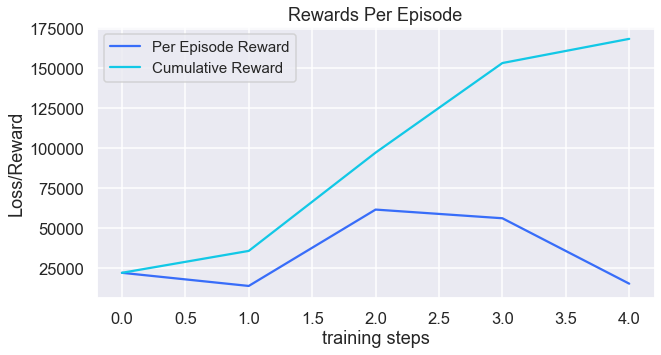

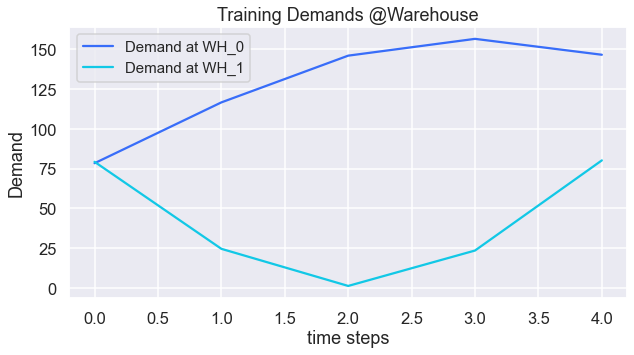

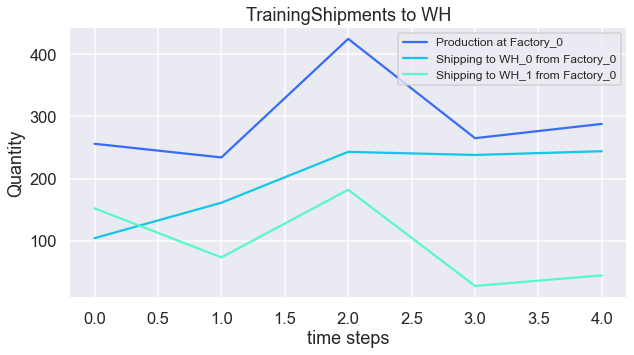

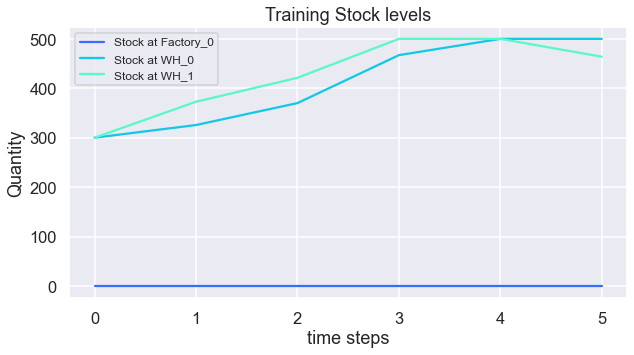

In [43]:
visualize(train_predict,episode_rewards,action_factory,action_warehouse,stock_warehouse,stock_factory,demand)

### Predicting using SAC Agent

In [44]:
train_predict='predict'

In [45]:
path=r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SupplyChain_RL\results\models"
base_filename='model-1F-NWH'
initial_factory_stock=[0]
initial_warehouse_stock= [300, 300]
initial_complete_state=None ##[  0 300 300   0   0   0   0   0   0   0   0]
demand=[[1,2,3,4,5],[6,7,8,9,10]] ##length of each demand list  should equal time steps and there should be N =warehousse lists

In [46]:
step_rewards,env.a_f,env.a_w,env.s_w,env.s_f,demand=predict(max_steps,initial_factory_stock,initial_warehouse_stock,initial_complete_state,path,base_filename,demand)

Model loaded
Initial STATE not passed as argument
Initial State [  0 300 300   0   0   0   0   0   0   0   0]
Initial Action
[247.83075  181.91711   73.038284]
-------------------------Demand-------------------------------------
Demand:- [1, 6]
-------------------------Action-------------------------------------
255
Factory Actions:- [255]
Warehouse Actions:- [[182, 73]]
[255] [[182, 73]] [1, 6]
Next State: [  0 481 367   0   0   0   1   0   0   0   6]
Initial Action
[ 50.95002 216.83499 225.4523 ]
-------------------------Demand-------------------------------------
Demand:- [2, 7]
-------------------------Action-------------------------------------
442
Factory Actions:- [442]
Warehouse Actions:- [[217, 225]]
[442] [[217, 225]] [2, 7]
Next State: [  0 500 500   0   0   1   2   0   0   6   7]
Initial Action
[ 67.143616  43.80478  129.62607 ]
-------------------------Demand-------------------------------------
Demand:- [3, 8]
-------------------------Action-------------------------------

<Figure size 432x288 with 0 Axes>

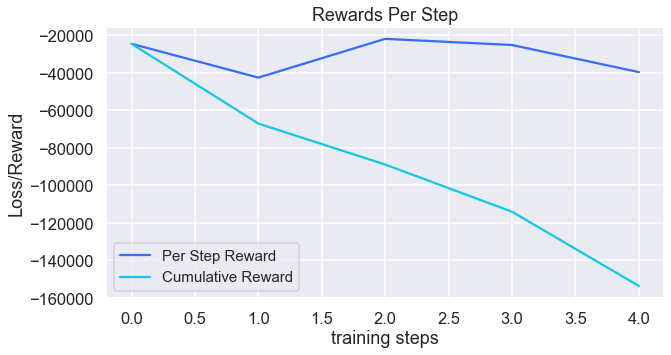

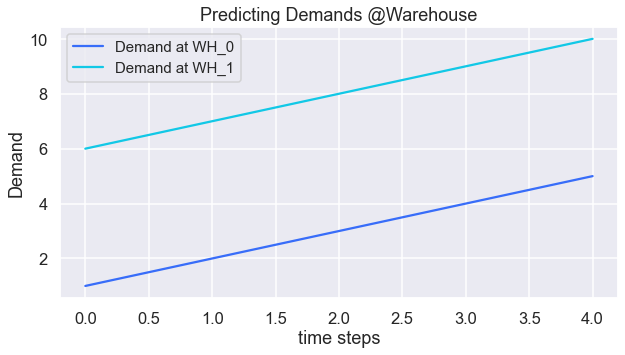

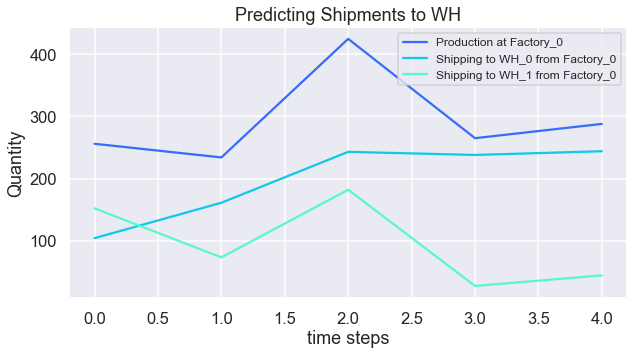

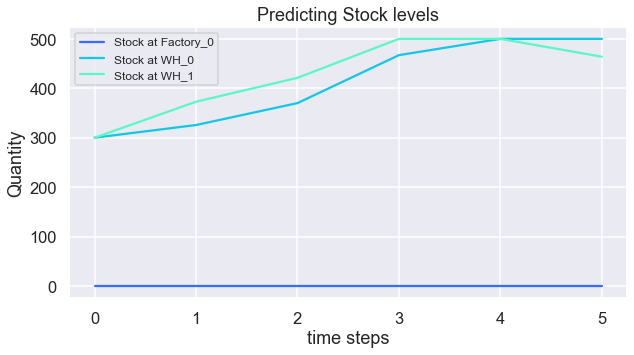

In [47]:
visualize(train_predict,step_rewards,action_factory,action_warehouse,stock_warehouse,stock_factory,demand)

## 2 Plants - N warehouses

### Parameters

In [22]:
# Supply Chain Parameters 
# 1 factory 2 warehouses [[1, 1]] M=1 N=2
## 1 factory 3 warehouses [[1,1,1]] M=1 N=2
## [[1,1][1,1]] 2 factory 2 warehouses M-Factories N- Warehouses [[M][N]] M=2 N=2
con_mat = [[1, 1, 1],[1, 1, 0]]            # [[X],[N]] M=length of Outer List M(Factory)=2 N(WH)=length of N list=3 
price = [200, 150,180]                     # [N]
k_pr = [60,80]                             # [M]
k_st = [[8,10], [8, 10,12]]                # [[M],[N]]
k_pe = [40, 40, 40]                         # [N]
k_tr = [[80,120,150],[80, 150,0]]          # [[X],[N]] or from Mi factory Nj warehouse lead time 
                                           # for example factory 0 to warehouse 0 Transportation cost=80 
                                           #             factory 0 to warehouse 1 Transportation cost=120
                                           #             factory 0 to warehouse 2 Transportation cost=150
                                           #             factory 0 to warehouse 0 Transportation cost=80
                                           #             factory 0 to warehouse 1 Transportation cost=150
                                           #             factory 0 to warehouse 2 Transportation cost=0 since No connections exist
lead_time = [[1,2,3],[2,4,0]]              # [[X],[N]] or from Mi factory Nj warehouse lead time 
                                           # for example factory 0 to warehouse 0 LT=1 
                                           #             factory 0 to warehouse 1 LT=2
                                           #             factory 0 to warehouse 2 LT=3
                                           #             factory 0 to warehouse 0 LT=2
                                           #             factory 0 to warehouse 1 LT=4
                                           #             factory 0 to warehouse 2 LT=0 since No connections exist
st_max = [[600,800], [500, 500, 500]]      # [[M],[N]]
de_hist_len = 4                            # demand length to store as buffer in state variable
zeta = 5                                   # Parameter used in transportation cost for truck capacity

In [23]:
factory_num = len(con_mat)
warehouse_num = len(con_mat[0])
print(np.sum(con_mat))
action_dim = np.sum(con_mat) + factory_num
state_dim = factory_num + warehouse_num + de_hist_len*warehouse_num
print('factory_num',factory_num)
print('warehouse_num',warehouse_num)
print('action_dim',action_dim)
print('state_dim',state_dim)
## Action Dim production level factory 1..N 
##            shipment to warehouse 1 shipment to warehouse 2...N 
## State Dim  factory stock 1...N  2 
##            Warehouse1 Stock Warehouse 2 stock..N dimension  3
##           (warehouse 1, warehouse 2..N) (warehouse 1, warehouse 2..N) * ...de_hist_len 3 *4 

5
factory_num 2
warehouse_num 3
action_dim 7
state_dim 17


In [24]:
# Supply Chain Environment
env = SupplyChainEnv(con_mat, price, k_pr, k_st, k_pe, k_tr, lead_time, st_max, de_hist_len, zeta)

# SAC Parameters
# tau = 0.005
# gamma = 0.9
# alpha = 0.000001
# a_lr = 0.00005
# q_lr = 0.00005
# p_lr = 0.00005
# buffer_maxlen = 1000

tau = 0.005
gamma = 0.9
alpha = 0.000001
a_lr = 0.000005
q_lr = 0.00005
p_lr = 0.00005
buffer_maxlen = 200 #2000

### Agent configure and Train

In [25]:
# SAC Agent
agent = SACAgent(env, gamma, tau, alpha, q_lr, p_lr, a_lr, buffer_maxlen)

# Training Parameters
max_episodes = 5 #1000
max_steps = 5 #50 length of horizon
batch_size = 5 #10

In [26]:
# Other Parameters
pi = 3.1415926

### Training Soft Actor Critic(SAC) Agent

In [27]:
train_predict='train'

In [28]:
path=r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SupplyChain_RL\results\models"
base_filename='model-NF-NWH'
initial_factory_stock=[0,0]
initial_warehouse_stock= [300, 300, 300]
initial_complete_state=None

In [29]:
episode_rewards,action_factory,action_warehouse,stock_warehouse,stock_factory,demand=run_model(con_mat,max_episodes,max_steps,initial_factory_stock,initial_warehouse_stock,initial_complete_state,path,base_filename)

Initial STATE not passed as argument
Initial State [  0   0 300 300 300   0   0   0   0   0   0   0   0   0   0   0   0]
-------------Episode------------ 0
------------------------------------Demand of N Warehouses-------------------------------------
Demand- 1
[85.14544656355031, 126.61465178384518, 157.3362656502707, 168.13876832750182, 157.4101904468097]
Demand- 2
[89.77110477818985, 26.715326146981976, 0.549525052802246, 26.498578795861324, 89.0018360366919]
Demand- 3
[78.27344853881637, 116.296595896413, 144.70554727039575, 155.27971025070084, 145.54300543407408]
Full Demand [[85.14544656355031, 126.61465178384518, 157.3362656502707, 168.13876832750182, 157.4101904468097], [89.77110477818985, 26.715326146981976, 0.549525052802246, 26.498578795861324, 89.0018360366919], [78.27344853881637, 116.296595896413, 144.70554727039575, 155.27971025070084, 145.54300543407408]]
------------------------------------Action Modifying and Editing--------------------------------
Initial Action
[110

Episode  2 Reward: -158724.1238 s0_final: 0.00 s1_final: 74.81 s2_final: 500.00
[[[13, 36, 8, 3, 0], [249, 131, 126, 209, 222], [165, 156, 116, 227, 186]], [[16, 160, 241, 236, 54], [151, 211, 138, 191, 227], [0, 0, 0, 0, 0]]]
[[427, 323, 250, 439, 408], [167, 371, 379, 427, 281]]
[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
[[300, 209.68256416745606, 87.3192025814188, -29.906555580156976, -11.731672008193101, 74.81092387841022], [300, 218.03055082295606, 194.0477324193343, 441.7264777236865, 500, 500], [300, 213.71013853715743, 83.52363229117921, -77.10827387668465, -7.675279473596248, -3.806332221686006]]
Initial STATE not passed as argument
Initial State [  0   0 300 300 300   0   0   0   0   0   0   0   0   0   0   0   0]
-------------Episode------------ 2
------------------------------------Demand of N Warehouses-------------------------------------
Demand- 1
[82.11445471547357, 122.61984709989251, 152.3153335122611, 164.2123950855825, 153.45245973786015]
Demand- 2
[82.25629381155005,

[322, 295] [[110, 4, 208], [249, 46, 0]] [113.57847535986652, 24.999080704122832, 114.51005363221073]
Next State: [  0.           0.         326.3059329  195.08074253 108.23447534
   0.           0.          76.11559174 113.57847536   0.
   0.          79.92017676  24.9990807    0.           0.
  77.25547103 114.51005363]
Initial Action
[121.32249  152.2796    87.718575 222.48383  146.10715  190.91737
  18.558037 114.3688  ]
[140.98845081694148, 0.16145529230063094, 140.84416708777465]
456
210
Factory Actions:- [456, 210]
Warehouse Actions:- [[88, 222, 146], [191, 19, 0]]
[456, 210] [[88, 222, 146], [191, 19, 0]] [140.98845081694148, 0.16145529230063094, 140.84416708777465]
Next State: [ 0.00000000e+00  0.00000000e+00  5.00000000e+02  3.17919287e+02
 -3.26096918e+01  0.00000000e+00  7.61155917e+01  1.13578475e+02
  1.40988451e+02  0.00000000e+00  7.99201768e+01  2.49990807e+01
  1.61455292e-01  0.00000000e+00  7.72554710e+01  1.14510054e+02
  1.40844167e+02]
Initial Action
[207.88913  

<Figure size 432x288 with 0 Axes>

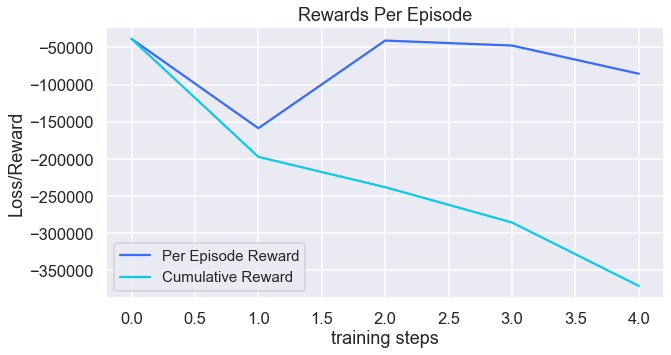

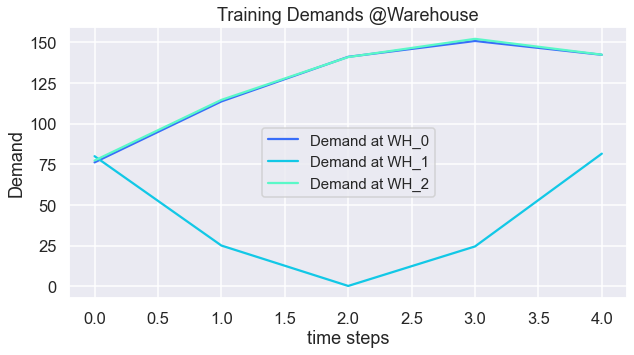

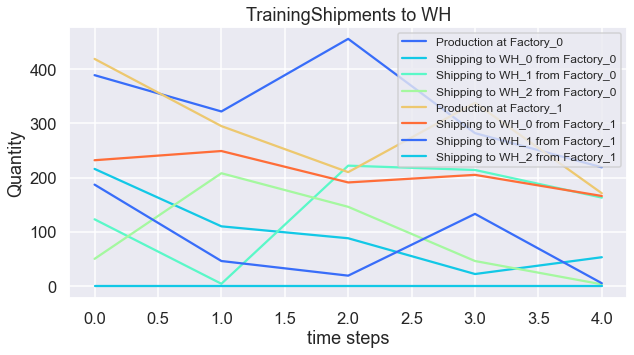

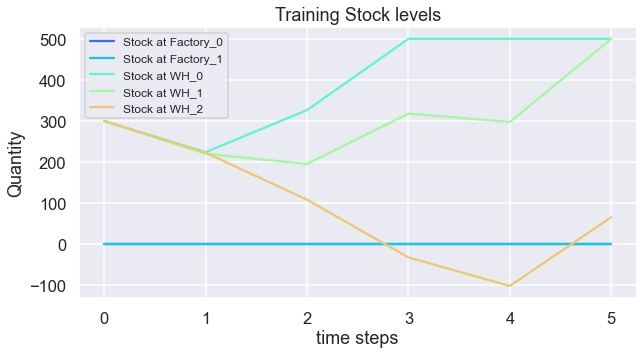

In [30]:
visualize(train_predict,episode_rewards,action_factory,action_warehouse,stock_warehouse,stock_factory,demand)

### Predicting using SAC Agent

In [31]:
train_predict='predict'

In [32]:
path=r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SupplyChain_RL\results\models"
base_filename='model-NF-NWH'
initial_factory_stock=[0,0]
initial_warehouse_stock= [300, 300, 300]
initial_complete_state=None##[  0 300 300   0   0   0   0   0   0   0   0]
demand=[[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]] ##length of each demand list  should equal time steps and there should be N =warehousse lists

In [33]:
step_rewards,env.a_f,env.a_w,env.s_w,env.s_f,demand=predict(max_steps,initial_factory_stock,initial_warehouse_stock,initial_complete_state,path,base_filename,demand)

Model loaded
Initial STATE not passed as argument
Initial State [  0   0 300 300 300   0   0   0   0   0   0   0   0   0   0   0   0]
Initial Action
[ 13.467117  55.14421  211.16191   12.935326 127.206696 180.145
 133.51433   35.259262]
-------------------------Demand-------------------------------------
Demand:- [1, 6, 11]
-------------------------Action-------------------------------------
351
314
Factory Actions:- [351, 314]
Warehouse Actions:- [[211, 13, 127], [180, 134, 0]]
[351, 314] [[211, 13, 127], [180, 134, 0]] [1, 6, 11]
Next State: [  0   0 299 294 289   0   0   0   1   0   0   0   6   0   0   0  11]
Initial Action
[ 51.362366  52.674896 215.74982  210.82187  213.92322  150.38017
  21.873726  54.749283]
-------------------------Demand-------------------------------------
Demand:- [2, 7, 12]
-------------------------Action-------------------------------------
641
172
Factory Actions:- [641, 172]
Warehouse Actions:- [[216, 211, 214], [150, 22, 0]]
[641, 172] [[216, 211, 214],

<Figure size 432x288 with 0 Axes>

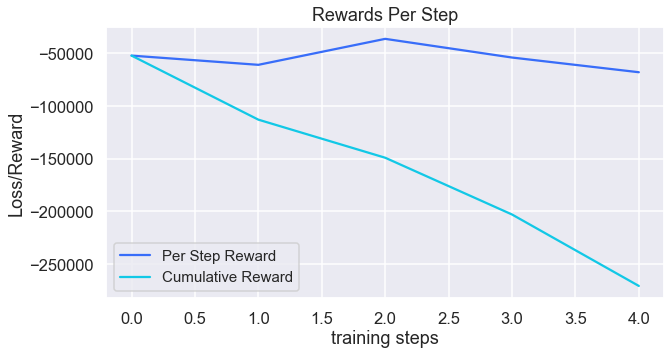

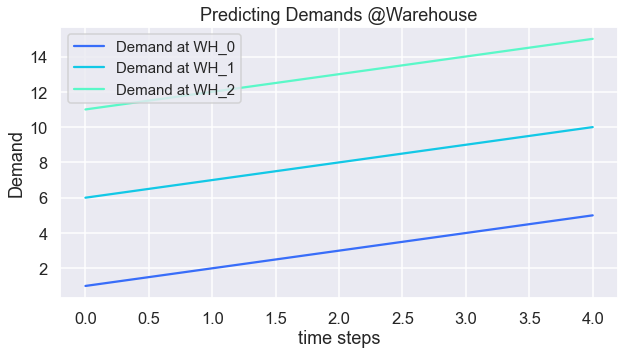

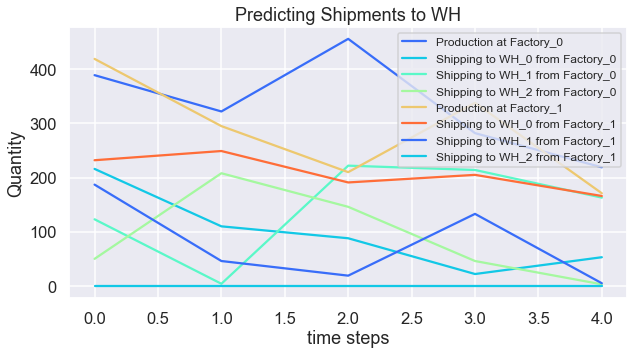

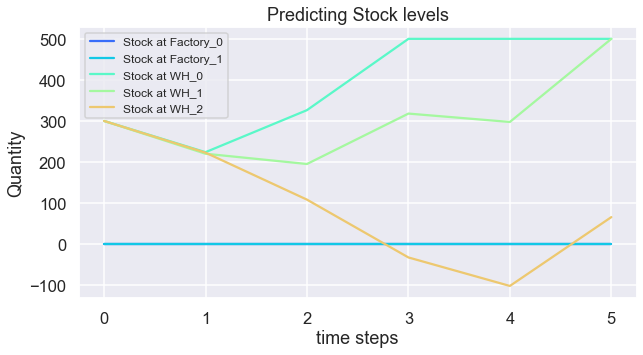

In [34]:
visualize(train_predict,step_rewards,action_factory,action_warehouse,stock_warehouse,stock_factory,demand)

## 3 Plants - N warehouses

### Parameters

In [8]:
# Supply Chain Parameters 
# 1 factory 2 warehouses [[1, 1]] M=1 N=2
## 1 factory 3 warehouses [[1,1,1]] M=1 N=2
## [[1,1][1,1]] 2 factory 2 warehouses M-Factories N- Warehouses [[M][N]] M=2 N=2
con_mat = [[1, 1, 1],[1, 1, 0],[0, 0, 1]]  # [[X],[N]] M=length of Outer List M(Factory)=2 N(WH)=length of N list=3 
price = [200, 150,180]                     # [N]
k_pr = [60,80,90]                          # [M]
k_st = [[8,10,12], [8, 10,12]]             # [[M],[N]]
k_pe = [40, 40, 40]                        # [N]
k_tr = [[80,120,150],[80, 150,0],[0,0,100]]# [[X],[N]] or from Mi factory Nj warehouse lead time 
                                           # for example factory 0 to warehouse 0 Transportation cost=80 
                                           #             factory 0 to warehouse 1 Transportation cost=120
                                           #             factory 0 to warehouse 2 Transportation cost=150
                                           #             factory 0 to warehouse 0 Transportation cost=80
                                           #             factory 0 to warehouse 1 Transportation cost=150
                                           #             factory 0 to warehouse 2 Transportation cost=0 since No connections exist
lead_time = [[1,2,3],[2,4,0],[0,0,3]]      # [[X],[N]] or from Mi factory Nj warehouse lead time 
                                           # for example factory 0 to warehouse 0 LT=1 
                                           #             factory 0 to warehouse 1 LT=2
                                           #             factory 0 to warehouse 2 LT=3
                                           #             factory 0 to warehouse 0 LT=2
                                           #             factory 0 to warehouse 1 LT=4
                                           #             factory 0 to warehouse 2 LT=0 since No connections exist
st_max = [[600,800,500], [500, 500, 500]]  # [[M],[N]]
de_hist_len = 4                            # demand length to store as buffer in state variable
zeta = 5                                   # Parameter used in transportation cost for truck capacity

In [10]:
factory_num = len(con_mat)
warehouse_num = len(con_mat[0])
print(np.sum(con_mat))
action_dim = np.sum(con_mat) + factory_num
state_dim = factory_num + warehouse_num + de_hist_len*warehouse_num
print('factory_num',factory_num)
print('warehouse_num',warehouse_num)
print('action_dim',action_dim)
print('state_dim',state_dim)
## Action Dim production level factory 1..N 
##            shipment to warehouse 1 shipment to warehouse 2...N 
## State Dim  factory stock 1...N  2 
##            Warehouse1 Stock Warehouse 2 stock..N dimension  3
##           (warehouse 1, warehouse 2..N) (warehouse 1, warehouse 2..N) * ...de_hist_len 3 *4 

6
factory_num 3
warehouse_num 3
action_dim 9
state_dim 18


In [11]:
# Supply Chain Environment
env = SupplyChainEnv(con_mat, price, k_pr, k_st, k_pe, k_tr, lead_time, st_max, de_hist_len, zeta)

# SAC Parameters
# tau = 0.005
# gamma = 0.9
# alpha = 0.000001
# a_lr = 0.00005
# q_lr = 0.00005
# p_lr = 0.00005
# buffer_maxlen = 1000

tau = 0.005
gamma = 0.9
alpha = 0.000001
a_lr = 0.000005
q_lr = 0.00005
p_lr = 0.00005
buffer_maxlen = 200 #2000

### Agent configure and Train

In [12]:
# SAC Agent
agent = SACAgent(env, gamma, tau, alpha, q_lr, p_lr, a_lr, buffer_maxlen)

# Training Parameters
max_episodes = 5 #1000
max_steps = 5 #50 length of horizon
batch_size = 5 #10

In [13]:
# Other Parameters
pi = 3.1415926

### Training Soft Actor Critic(SAC) Agent

In [14]:
train_predict='train'

In [15]:
path=r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SupplyChain_RL\results\models"
base_filename='model-3F-NWH'
initial_factory_stock=[600,500,200]
initial_warehouse_stock= [300, 300, 300]
initial_complete_state=None

In [16]:
episode_rewards,action_factory,action_warehouse,stock_warehouse,stock_factory,demand=run_model(con_mat,max_episodes,max_steps,initial_factory_stock,initial_warehouse_stock,initial_complete_state,path,base_filename)

Initial STATE not passed as argument
Initial State [600 500 200 300 300 300   0   0   0   0   0   0   0   0   0   0   0   0]
-------------Episode------------ 0
------------------------------------Demand of N Warehouses-------------------------------------
Demand- 1
[80.75048554839073, 121.6449628073671, 152.42736842383223, 161.56216940597955, 150.6340614241797]
Demand- 2
[77.30932992977786, 23.639082648751824, 1.3870258738997507, 23.417698545622542, 77.37091671672556]
Demand- 3
[76.35087526906254, 113.57401426292589, 141.3339422846101, 151.3719883708262, 140.72335997478]
Full Demand [[80.75048554839073, 121.6449628073671, 152.42736842383223, 161.56216940597955, 150.6340614241797], [77.30932992977786, 23.639082648751824, 1.3870258738997507, 23.417698545622542, 77.37091671672556], [76.35087526906254, 113.57401426292589, 141.3339422846101, 151.3719883708262, 140.72335997478]]
------------------------------------Action Modifying and Editing--------------------------------
Initial Action
[2

 114.41317121 142.59679729 152.57634984]
Initial Action
[109.35568  215.73175  182.51492  250.       214.97859  244.6708
 152.51518   97.70333   80.24809  183.7107   241.82529   92.184906]
[160.38474195856034, 84.40141822381888, 143.4460976211428]
710
251
92
Factory Actions:- [710, 251, 92]
Warehouse Actions:- [[250, 215, 245], [153, 98, 0], [0, 0, 92]]
[710, 251, 92] [[250, 215, 245], [153, 98, 0], [0, 0, 92]] [160.38474195856034, 84.40141822381888, 143.4460976211428]
Next State: [600.         500.         200.         -31.55319274 126.00013398
  31.55390238 129.11033741 161.0785897  173.14261457 160.38474196
  24.75041894   1.36685073  25.4971768   84.40141822 114.41317121
 142.59679729 152.57634984 143.44609762]
Episode  2 Reward: -62005.4571 a1_final: 250.00 a2_final: 215.00 a0_final: 710.00
Episode  2 Reward: -62005.4571 s0_final: 600.00 s1_final: -31.55 s2_final: 126.00
[[[248, 12, 0, 55, 250], [1, 0, 46, 0, 215], [18, 4, 4, 33, 245]], [[7, 13, 44, 184, 153], [0, 0, 8, 118, 98], 

Model Saved


<Figure size 432x288 with 0 Axes>

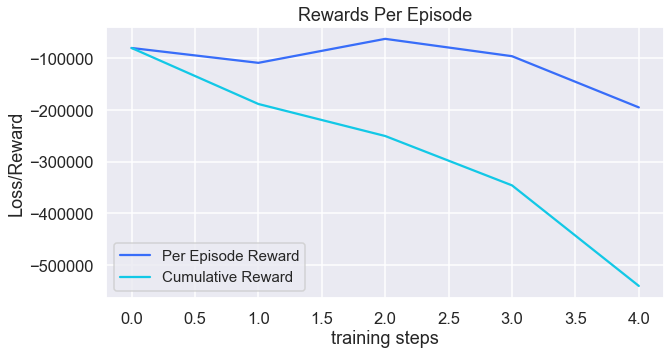

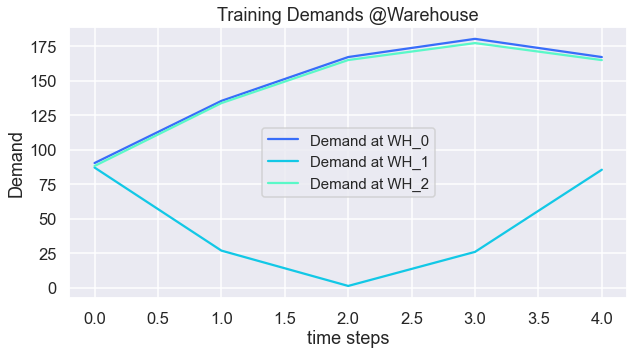

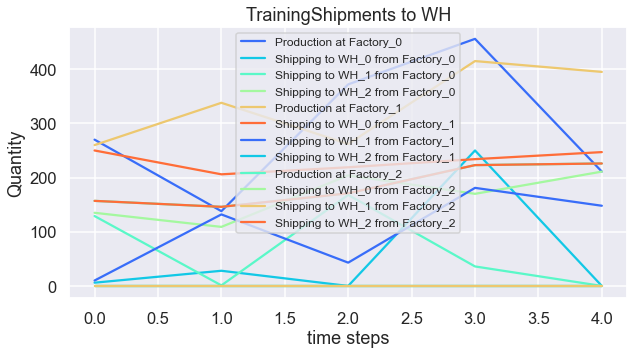

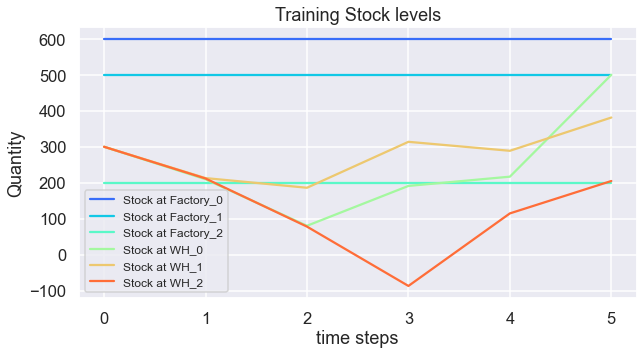

In [17]:
visualize(train_predict,episode_rewards,action_factory,action_warehouse,stock_warehouse,stock_factory,demand)

### Predicting using SAC Agent

In [18]:
train_predict='predict'

In [19]:
path=r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SupplyChain_RL\results\models"
base_filename='model-3F-NWH'
initial_factory_stock=[600,500,300]
initial_warehouse_stock= [300, 300, 300]
initial_complete_state=None##[  0 300 300   0   0   0   0   0   0   0   0]
demand=[[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]] ##length of each demand list  should equal time steps and there should be N =warehousse lists

In [20]:
step_rewards,env.a_f,env.a_w,env.s_w,env.s_f,demand=predict(max_steps,initial_factory_stock,initial_warehouse_stock,initial_complete_state,path,base_filename,demand)

Model loaded
Initial STATE not passed as argument
Initial State [600 500 300 300 300 300   0   0   0   0   0   0   0   0   0   0   0   0]
Initial Action
[  9.972702  25.885834  73.1577    41.899887 201.87204  153.08722
 245.921    196.0718    20.810486 196.66302  223.95654  192.56424 ]
-------------------------Demand-------------------------------------
Demand:- [1, 6, 11]
-------------------------Action-------------------------------------
397
442
193
Factory Actions:- [397, 442, 193]
Warehouse Actions:- [[42, 202, 153], [246, 196, 0], [0, 0, 193]]
[397, 442, 193] [[42, 202, 153], [246, 196, 0], [0, 0, 193]] [1, 6, 11]
Next State: [600 500 300 299 294 289   0   0   0   1   0   0   0   6   0   0   0  11]
Initial Action
[4.3760826e+01 1.7495743e+02 1.3486186e+02 6.6291809e-02 2.3815805e+02
 1.4592535e+02 2.2900641e+02 5.7399361e+01 1.3008308e+01 1.1517097e+01
 1.8866910e+02 1.8823340e+02]
-------------------------Demand-------------------------------------
Demand:- [2, 7, 12]
----------

<Figure size 432x288 with 0 Axes>

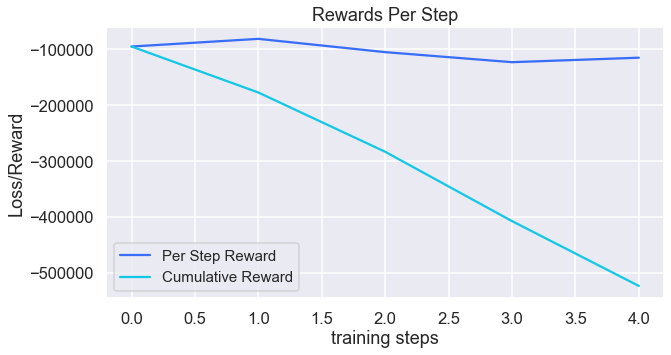

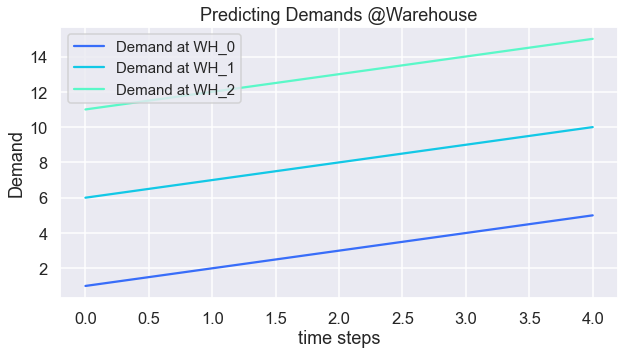

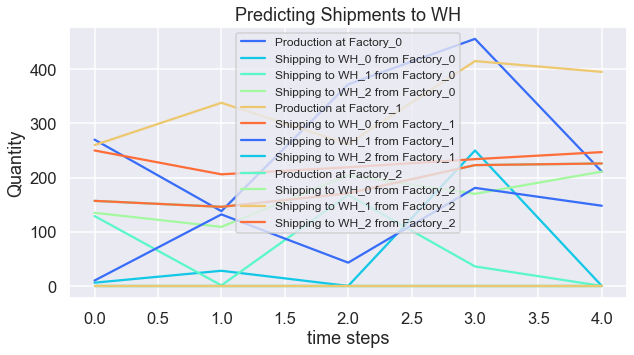

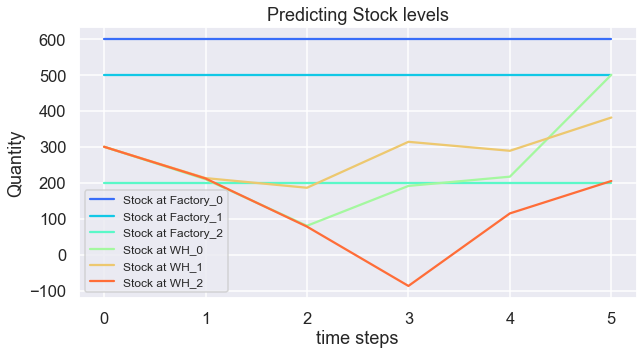

In [21]:
visualize(train_predict,step_rewards,action_factory,action_warehouse,stock_warehouse,stock_factory,demand)